### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from model import *

In [68]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.2.4-tf
TensorFlow version: 1.14.0


In [69]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [70]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [71]:
# Loading full images of desired resolution:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

In [ ]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)
img_train, cup_train, disc_train, disc_locations

### Train images

In [73]:
red_channel_train = get_color_channel(0, img_train)
len(red_channel_train)

50

### Test images

In [74]:
red_channel_test = get_color_channel(0, img_test)
len(red_channel_test)

51

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

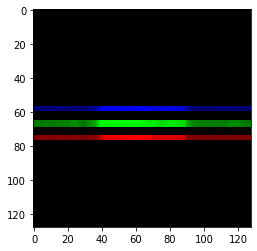

In [89]:
gen = data_generator(red_channel_train, cup_train, disc_locations, 128, 'train')
batch = next(gen)

plt.imshow(batch[0][0])
plt.show()

In [76]:
X_valid, Y_valid = next(data_generator(red_channel_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))
len(X_valid), len(Y_valid)

(51, 51)

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.squeeze(X_valid[10]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(Y_valid[10]), cmap=plt.cm.Greys_r)
plt.show()

### Training and test cup

In [ ]:
train(red_channel_train, cup_train, disc_locations, 'cup_red', model, 1000)

### Visual check

In [ ]:
pred_iou, pred_dice, pred_cup = predict(red_channel_test, X_valid, Y_valid, model)
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Training and test disc

In [79]:
X_valid, Z_valid = next(data_generator(red_channel_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [ ]:
num = 1
for i in range(num):
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(X_valid[i]), cmap=plt.cm.Greys_r)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(Z_valid[i]), cmap=plt.cm.Greys_r)
    plt.show()
    print('=========================')

In [ ]:
train(red_channel_train, disc_train, disc_locations, 'disc_red', model, 1000)

image #0


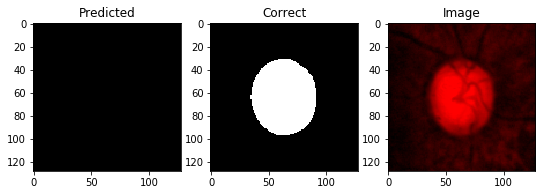

IOU: 0.0
Dice: 0.0
0.0
0.0


In [36]:
pred_iou, pred_dice, pred_disc = predict(red_channel_test, X_valid, Z_valid, model)

print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Cálculo do CDR

In [ ]:
cdrs = calculate_cdr(pred_cup, pred_disc)
areas = calculate_area(pred_cup, pred_disc)
d = {'cdr': cdrs, 'area': areas}
df = pd.DataFrame(data=d)
df